In [3]:
import sys
import os

script_path = os.path.abspath('')
current_file_dir = os.path.dirname(script_path)
sys.path.insert(0, f"{current_file_dir}/FinRL/")

import logging
import pandas as pd
import numpy as np
import datetime
import torch
import yfinance as yf

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers
from finrl.config import INDICATORS

#from finrl.meta.preprocessor.preprocessors import GroupByScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE, EI3, GPM

import src.neel_env as env 

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
print(os.getcwd())

/Users/neel/PycharmProjects/cs234-final-project/src


In [5]:
import datetime

In [6]:
len(env.STOCKS)
print(env.STOCKS)

['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BIIB', 'BK', 'BKNG', 'BLK', 'BMY', 'BR', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CE', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CPRI', 'CPRT', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTVA', 'CVS', 'CVX', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DLR', 'DLTR', 'DOV', 'DOW', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EO

In [7]:
def load_data() -> pd.DataFrame:
    # Define the path for saving the data
    script_path = os.path.abspath('')
    current_file_dir = os.path.dirname(script_path)
    data_path = os.path.join(
        current_file_dir, 
        "src",
        "data", 
        f"{env.TIME_RANGE_START.date()}_{env.TIME_RANGE_END.date()}_S&P500.pkl"
    )

    # Check if data already exists
    if not os.path.isfile(data_path): 
        # Download data
        df = YahooDownloader(
            start_date=env.TIME_RANGE_START - datetime.timedelta(days=120),
            end_date=env.TIME_RANGE_END,
            ticker_list=my_tickers,
        ).fetch_data()

        # Find tickers present in the DataFrame
        tickers_in_df = df['tic'].unique().tolist()

        # Identify missing tickers
        #missing_tickers = [ticker for ticker in env.STOCKS if ticker not in tickers_in_df]
        #print(f"Missing tickers: {missing_tickers}")

        # Update env.STOCKS to exclude missing tickers
        #env.STOCKS = [ticker for ticker in env.STOCKS if ticker in tickers_in_df]
        #print(f"Updated env.STOCKS: {env.STOCKS}")

        # Save the DataFrame to a pickle file
        df.to_pickle(data_path)
    else:
        # Load the DataFrame from the pickle file
        df = pd.read_pickle(data_path)

        # Update env.STOCKS based on the loaded data
        tickers_in_df = df['tic'].unique().tolist()
        #env.STOCKS = [ticker for ticker in env.STOCKS if ticker in tickers_in_df]
        print(f"Loaded data for tickers: {tickers_in_df}")
        print(f"Updated env.STOCKS after loading: {env.STOCKS}")

    return df

In [6]:
#from finrl.meta.preprocessor.preprocessors import GroupByScaler
from sklearn.preprocessing import MaxAbsScaler

In [8]:
df = load_data()

# preprocess data, calculate set of technical indicators on the data
fe = FeatureEngineer(
       use_technical_indicator=True,
       tech_indicator_list = env.INDICATORS
    )

df = fe.preprocess_data(df)
fmt = "%Y-%m-%d"
train_df = data_split(df, env.TRAIN_START.strftime(fmt), env.TRAIN_END.strftime(fmt))
validation_df = data_split(df, env.VALIDATION_START.strftime(fmt), env.VALIDATION_END.strftime(fmt))
test_df = data_split(df, env.TEST_START.strftime(fmt), env.TEST_END.strftime(fmt))

Loaded data for tickers: ['A', 'AAL', 'AAP', 'AAPL', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'AMAT', 'AMD', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ARE', 'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BIIB', 'BK', 'BKNG', 'BLK', 'BMY', 'BR', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CAT', 'CB', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CE', 'CF', 'CHD', 'CHRW', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CVS', 'CVX', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DGX', 'DHI', 'DHR', 'DIS', 'DLR', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'ES', 'ESS', 'ETN', 'ETR', 'EVRG', 'EW', 'EXC', 'EXPD', 

In [7]:
train_df.head(50)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2010-01-04,22.453505,22.625179,22.267525,20.122227,3815561,A,0,0.384161,20.062781,18.594398,66.301696,219.854986,34.034398,19.153832,18.217901
0,2010-01-04,4.840000,4.940000,4.660000,4.496876,9837300,AAL,0,0.262089,4.990097,3.970660,56.942778,56.164059,14.144787,4.087727,3.736084
0,2010-01-04,40.700001,41.040001,40.360001,36.130333,1701700,AAP,0,0.273405,37.345576,35.603660,51.680174,17.696575,0.583797,36.168844,35.210987
0,2010-01-04,7.622500,7.660714,7.585000,6.461976,493729600,AAPL,0,0.116751,6.525678,5.556234,62.199882,168.773584,22.998344,6.045440,5.992478
0,2010-01-04,26.000362,26.177889,25.870815,18.952164,10829095,ABT,0,0.110761,19.020575,18.520435,60.308900,69.583601,20.391555,18.778973,18.359622
0,2010-01-04,41.520000,42.200001,41.500000,32.212452,3650100,ACN,0,0.229289,32.947528,31.102970,60.580378,46.787606,19.535278,31.768616,30.673433
0,2010-01-04,36.650002,37.299999,36.650002,37.090000,4710200,ADBE,0,0.354561,38.064119,35.385880,56.168586,61.331407,12.666219,36.478000,35.719167
0,2010-01-04,31.790001,32.189999,31.610001,22.530378,2102700,ADI,0,0.502602,22.751215,21.284394,64.116079,124.419085,34.473746,21.613983,20.424351
0,2010-01-04,31.480000,31.840000,31.330000,21.623394,3472500,ADM,0,0.076445,21.976179,20.648093,54.062779,62.894013,8.127988,21.394360,21.324568
0,2010-01-04,38.226513,38.226513,37.489025,26.725901,3930120,ADP,0,0.063244,27.189874,26.424026,55.760278,-36.248684,13.880175,26.887609,26.237253


In [9]:
features = ["close", "high", "low", "boll_ub", "macd", "boll_lb", "rsi_30", "cci_30", "dx_30"]

policy_kwargs:
{'edge_index': tensor([[ 0,  0,  0,  0,  1,  1,  4,  6,  8,  8],
        [ 1,  4,  6,  8,  2,  3,  5,  7,  9, 10]]), 'edge_type': tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1]), 'nodes_to_select': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'softmax_temperature': 5}


/var/folders/18/77j_5hc96gvgpth3twqfjmm80000gn/T/ipykernel_20925/4085184197.py:93: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(edge_colors, edge_labels, title="Edge Type")


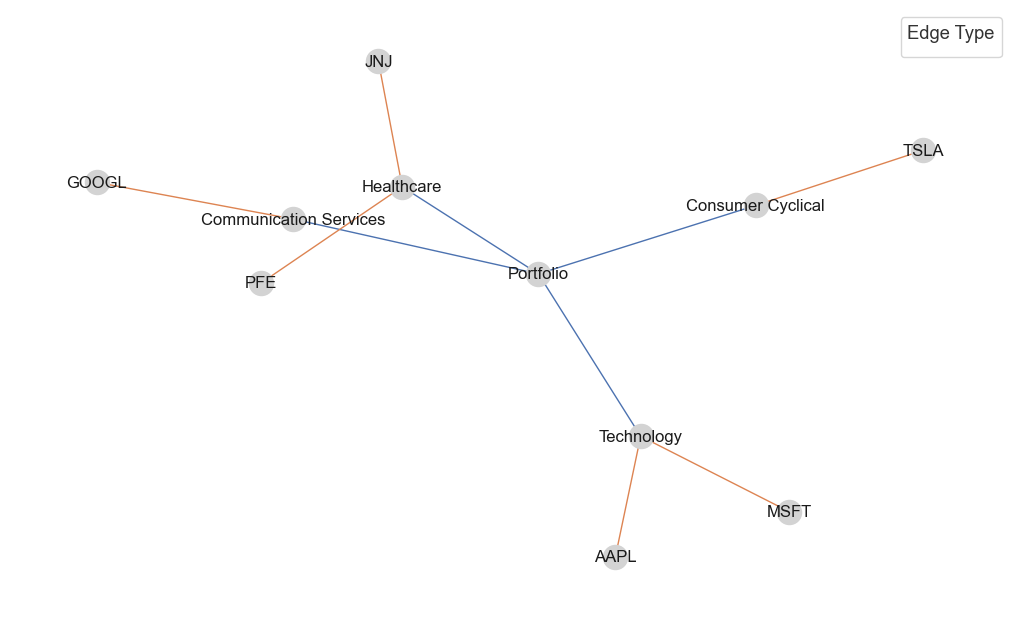

In [10]:
import yfinance as yf
import networkx as nx
import numpy as np
import torch
from collections import defaultdict
import matplotlib.pyplot as plt

def get_sectoral_data(tickers):
    ticker_to_info = {}
    for ticker in tickers:
        try:
            ticker_info = yf.Ticker(ticker).info
            sector = ticker_info.get("sector", "Unknown")
            ticker_to_info[ticker] = sector
        except Exception as e:
            print(f"Failed to fetch info for ticker {ticker}: {e}")
            ticker_to_info[ticker] = "Unknown"

    return ticker_to_info

def create_graph(tickers):
    ticker_to_info = get_sectoral_data(tickers)

    sector_to_tickers = defaultdict(list)
    unknown_tickers = []
    for ticker, sector in ticker_to_info.items():
        if sector == "Unknown":
            unknown_tickers.append(ticker)
        else:
            sector_to_tickers[sector].append(ticker)

    G = nx.Graph()
    G.add_node("Portfolio")

    for sector, tickers in sector_to_tickers.items():
        G.add_node(sector)
        G.add_edge("Portfolio", sector, type=0)
        for ticker in tickers:
            G.add_node(ticker)
            G.add_edge(sector, ticker, type=1)

    for ticker in unknown_tickers:
        G.add_node(ticker)
        G.add_edge("Portfolio", ticker, type=2)

    return G

def fetch_edges_and_types(G):
    # Create a mapping from node names to numeric indices
    node_mapping = {node: i for i, node in enumerate(G.nodes())}
    
    edge_index = []
    edge_types = []

    for u, v, attr in G.edges(data=True):
        edge_index.append((node_mapping[u], node_mapping[v]))
        edge_types.append(attr['type'])

    edge_index = np.array(edge_index).T  # Transpose to match required format
    edge_types = np.array(edge_types)

    return edge_index, edge_types, node_mapping

def visualize_graph(G, edge_index, edge_types, node_mapping):
    # Reverse the node_mapping to get node names from indices
    reverse_node_mapping = {v: k for k, v in node_mapping.items()}

    # Create a NetworkX graph for visualization
    G_vis = nx.Graph()

    # Add nodes to the visualization graph
    for node in G.nodes():
        G_vis.add_node(node)

    # Add edges to the visualization graph
    for i in range(edge_index.shape[1]):
        u = reverse_node_mapping[edge_index[0, i]]
        v = reverse_node_mapping[edge_index[1, i]]
        edge_type = edge_types[i]
        color = f"C{edge_type}"
        G_vis.add_edge(u, v, color=color)

    # Set up the plot
    pos = nx.spring_layout(G_vis)
    colors = [G_vis[u][v]['color'] for u, v in G_vis.edges()]

    # Draw the nodes and edges
    nx.draw(G_vis, pos, node_color='lightgray', edge_color=colors, with_labels=True)

    # Add a legend for the edge colors
    edge_colors = [f"C{i}" for i in set(edge_types)]
    edge_labels = [f"Type {i}" for i in set(edge_types)]
    plt.legend(edge_colors, edge_labels, title="Edge Type")

    # Show the plot
    plt.axis('off')
    plt.show()

# Example usage
my_tickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "PFE", "JNJ"]
G = create_graph(my_tickers)
new_edge_index, new_edge_type, node_mapping = fetch_edges_and_types(G)

# Define nodes_to_select based on your requirements
nodes_to_select = list(node_mapping.values())

# Define policy_kwargs for the GPM model
policy_kwargs = {
    "edge_index": torch.from_numpy(new_edge_index).long(),
    "edge_type": torch.from_numpy(new_edge_type).long(),
    "nodes_to_select": nodes_to_select,
    "softmax_temperature": 5
}

# Print policy_kwargs to verify
print("policy_kwargs:")
print(policy_kwargs)

# Visualize the graph
visualize_graph(G, new_edge_index, new_edge_type, node_mapping)



In [11]:
def fetch_edges_and_types(G):
    edge_index = []
    edge_types = []

    for u, v, attr in G.edges(data=True):
        edge_index.append((u, v))
        edge_types.append(attr['type'])

    edge_index = np.array(edge_index).T  # Transpose to match required format
    edge_types = np.array(edge_types)

    return edge_index, edge_types
edge_index, edge_types = fetch_edges_and_types(G)
print(new_edge_index, new_edge_type)

[[ 0  0  0  0  1  1  4  6  8  8]
 [ 1  4  6  8  2  3  5  7  9 10]] [0 0 0 0 1 1 1 1 1 1]


In [12]:
def run_experiment(train_df, validation_df, test_df, model_kwargs, policy_kwargs, algorithm, kwargs):
    results = {
        "train": {},
        "validation": {},
        "test": {},
    }
    environment_train = PortfolioOptimizationEnv(
       train_df,
       **kwargs
    )
    environment_validation = PortfolioOptimizationEnv(
       validation_df,
       **kwargs
    )
    environment_test = PortfolioOptimizationEnv(
        test_df,
        **kwargs
    )

    model_kwargs["validation_env"] = environment_validation
    
    model = DRLAgent(environment_train).get_model(algorithm, device, model_kwargs, policy_kwargs)
    model = DRLAgent.train_model(model, episodes=5)
    DRLAgent.DRL_validation(model, environment_validation, policy=model.train_policy)
    DRLAgent.DRL_validation(model, environment_test, policy=model.train_policy)
    
    results["train"] = environment_train._asset_memory["final"]
    results["validation"] = environment_validation._asset_memory["final"]
    results["test"] = environment_test._asset_memory["final"]
    return results, environment_train, environment_validation, environment_test


In [13]:
import copy
"""
Create kwargs
"""
model_kwargs = {
    "lr": env.LR,
}

policy_kwargs = {
    "initial_features": 9,
    "time_window": 50,
}

environment_kwargs = {
    "initial_amount": env.INITIAL_AMT,
    "comission_fee_pct": env.COMISSION_FEE_PCT,
    "time_window": env.TIME_WINDOW,
    "features": features,
    "normalize_df": None
}

In [14]:
policy_to_model_args = {}
policy_to_policy_args = {}

In [15]:
for policy in [EIIE, GPM]:
    model_kwargs_specific = copy.deepcopy(model_kwargs)
    policy_kwargs_specific = copy.deepcopy(policy_kwargs)
    env_kwargs_specific = copy.deepcopy(environment_kwargs)
    model_kwargs_specific["policy"]=policy
    if policy == GPM:
        model_kwargs_specific["policy"]=policy
        edge_index, edge_type = fetch_edges_and_types(G)
        policy_kwargs_specific["edge_index"] = new_edge_index
        policy_kwargs_specific["edge_type"] = new_edge_type
        policy_kwargs_specific["nodes_to_select"] = list(range(len(my_tickers)))
        policy_kwargs_specific["softmax_temperature"] = 6
        
    elif policy == EIIE:
        policy_kwargs_specific["k_size"] = 3
    policy_to_policy_args[policy] = policy_kwargs_specific
    policy_to_model_args[policy] = model_kwargs_specific

In [16]:
config_to_results = {}

In [ ]:
for policy in [GPM]:
    results, environment_train, environment_validation, environment_test = run_experiment(
        train_df, validation_df, test_df, policy_to_model_args[policy], policy_to_policy_args[policy], "pg", environment_kwargs
    )
    config_to_results[policy] = (results, environment_train, environment_validation, environment_test)

  0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
config_to_results.keys()

dict_keys([])

In [18]:
gpm = config_to_results[GPM][3]._actions_memory

KeyError: <class 'finrl.agents.portfolio_optimization.architectures.GPM'>

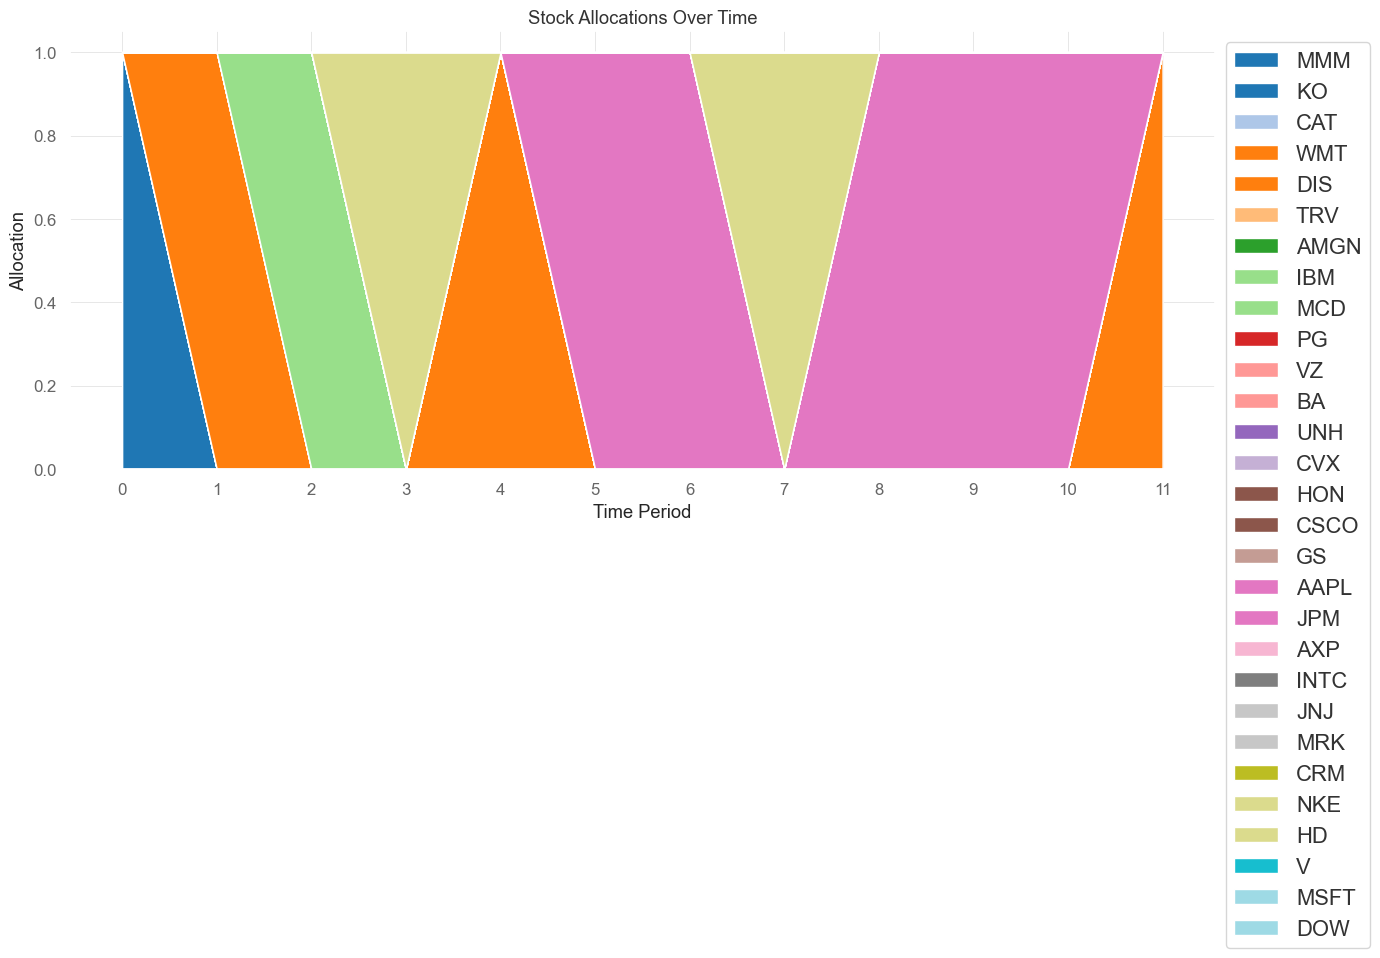

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data: list of weight vectors
weights = gpm
weights = [l.tolist() for l in weights]

# Convert the list of lists into a numpy array for easier manipulation
weights_array = np.array(weights)

# Preprocess the data to concatenate periods with the same allocations
concatenated_weights = [weights[0]]
time_labels = ['Period 0']
start_period = 0

for i in range(1, len(weights)):
    if weights[i] != weights[i-1]:
        concatenated_weights.append(weights[i])
        time_labels.append(f'Periods {start_period}-{i-1}')
        start_period = i

# Add the last period
time_labels.append(f'Periods {start_period}-{len(weights)-1}')

# Convert the concatenated weights list to a numpy array
concatenated_weights_array = np.array(concatenated_weights)

# Number of time periods and stocks
num_periods, num_stocks = concatenated_weights_array.shape

# Colors for each stock
colors = plt.cm.tab20(np.linspace(0, 1, num_stocks))

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Plot stacked area chart
ax.stackplot(range(num_periods), concatenated_weights_array.T, labels=[f'{mapping[i]}' for i in range(num_stocks)], colors=colors)

ax.set_xlabel('Time Period')
ax.set_ylabel('Allocation')
ax.set_title('Stock Allocations Over Time')
ax.set_xticks(range(num_periods))
# ax.set_xticklabels(time_labels, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='large')

plt.tight_layout()
plt.show()


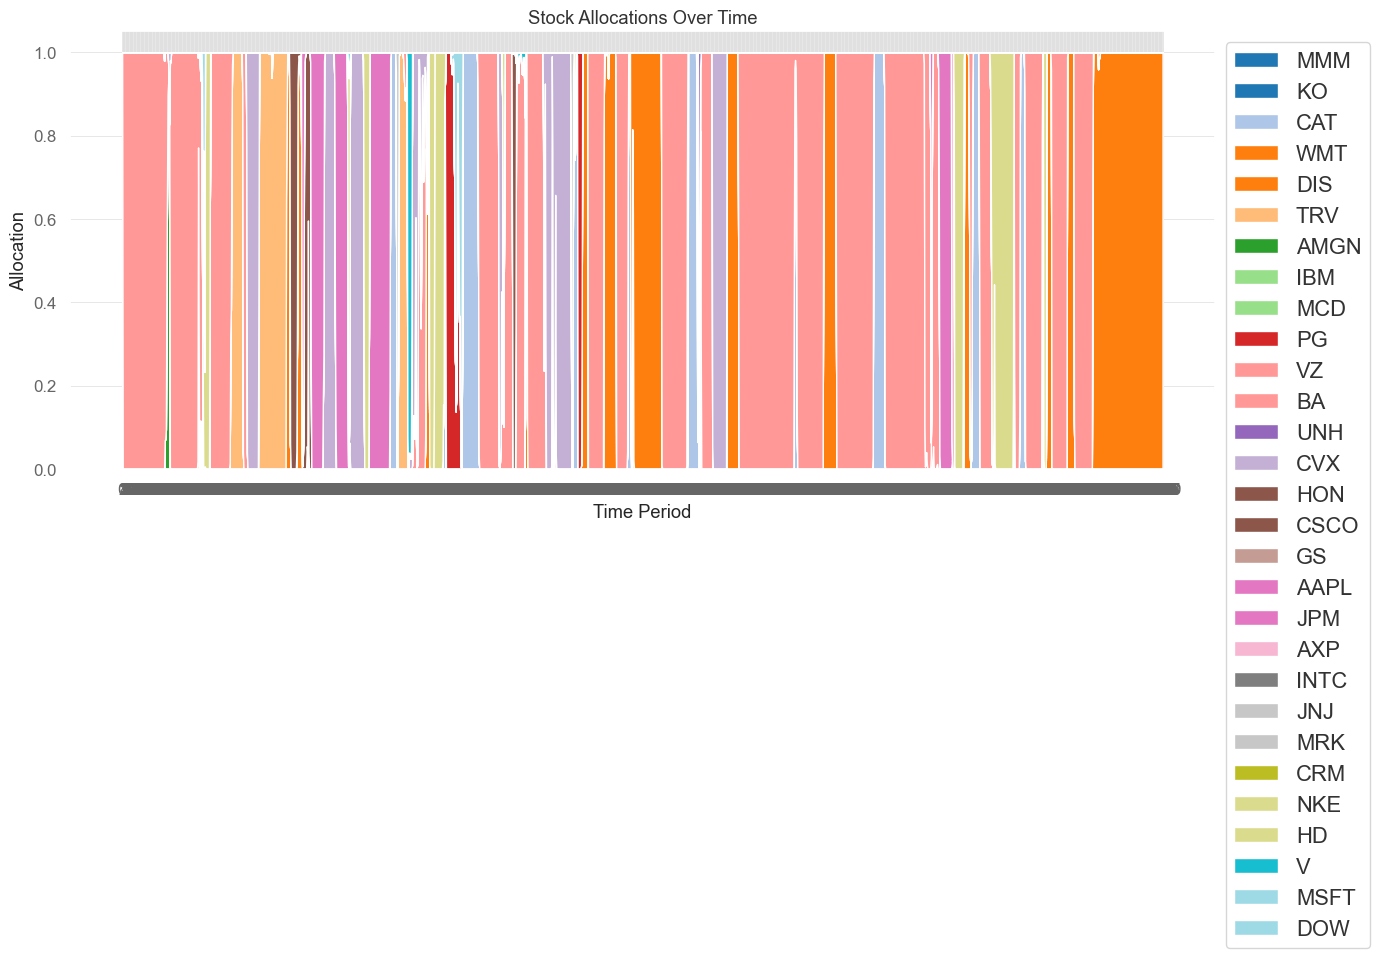

In [118]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data: list of weight vectors
weights = config_to_results[EI3][1]._actions_memory
weights = [l.tolist() for l in weights]

# Convert the list of lists into a numpy array for easier manipulation
weights_array = np.array(weights)

# Preprocess the data to concatenate periods with the same allocations
concatenated_weights = [weights[0]]
time_labels = ['Period 0']
start_period = 0

for i in range(1, len(weights)):
    if weights[i] != weights[i-1]:
        concatenated_weights.append(weights[i])
        time_labels.append(f'Periods {start_period}-{i-1}')
        start_period = i

# Add the last period
time_labels.append(f'Periods {start_period}-{len(weights)-1}')

# Convert the concatenated weights list to a numpy array
concatenated_weights_array = np.array(concatenated_weights)

# Number of time periods and stocks
num_periods, num_stocks = concatenated_weights_array.shape

# Colors for each stock
colors = plt.cm.tab20(np.linspace(0, 1, num_stocks))

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Plot stacked area chart
ax.stackplot(range(num_periods), concatenated_weights_array.T, labels=[f'{mapping[i]}' for i in range(num_stocks)], colors=colors)

ax.set_xlabel('Time Period')
ax.set_ylabel('Allocation')
ax.set_title('Stock Allocations Over Time')
ax.set_xticks(range(num_periods))
# ax.set_xticklabels(time_labels, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='large')

plt.tight_layout()
plt.show()


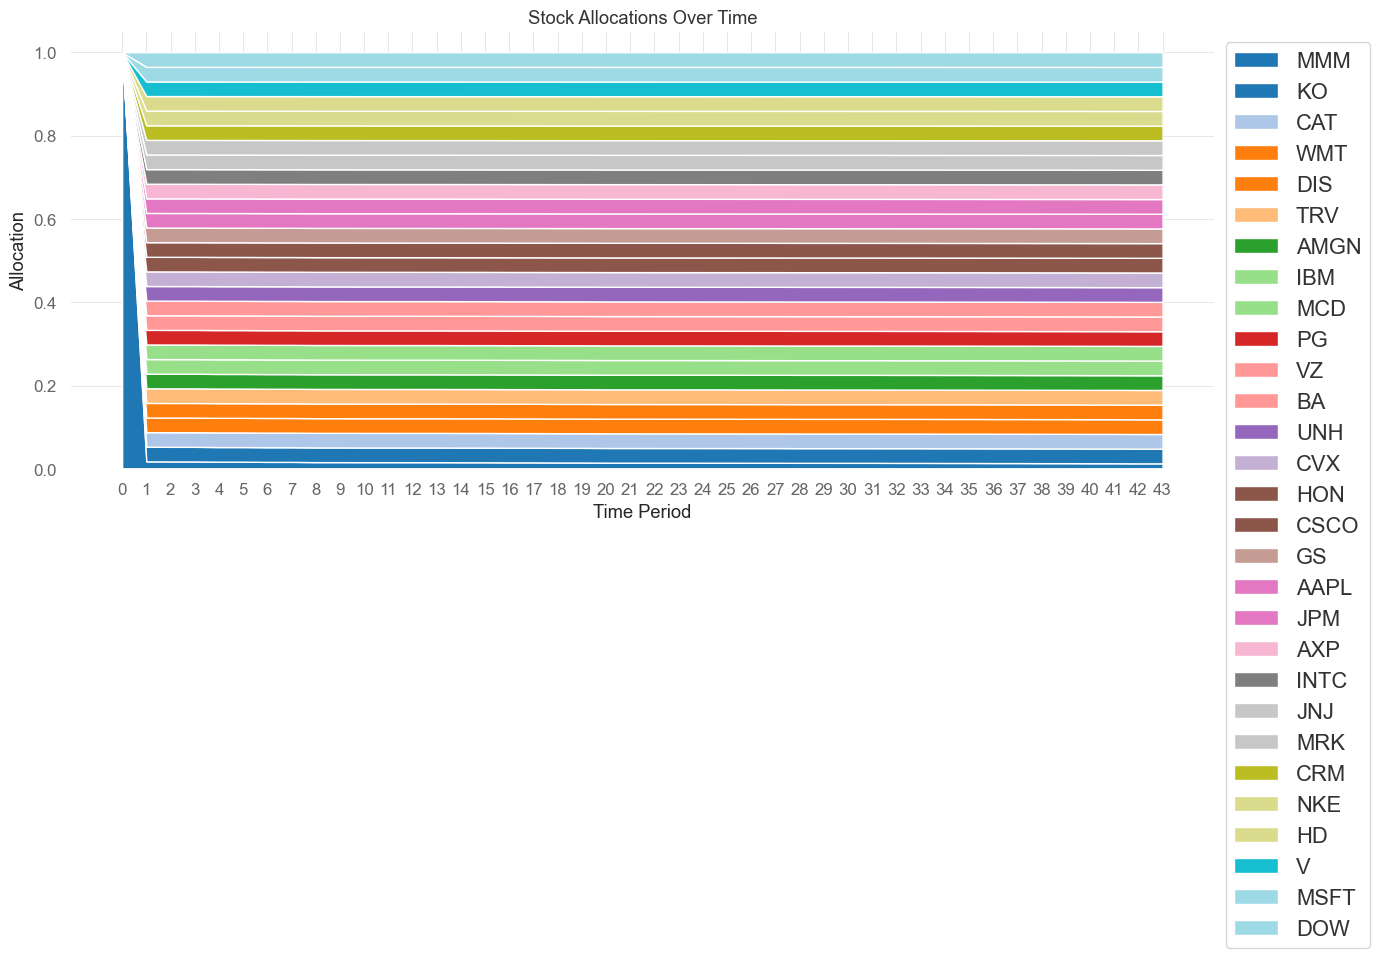

In [117]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data: list of weight vectors
weights = config_to_results[EIIE][3]._actions_memory
weights = [l.tolist() for l in weights]

# Convert the list of lists into a numpy array for easier manipulation
weights_array = np.array(weights)

# Preprocess the data to concatenate periods with the same allocations
concatenated_weights = [weights[0]]
time_labels = ['Period 0']
start_period = 0

for i in range(1, len(weights)):
    if weights[i] != weights[i-1]:
        concatenated_weights.append(weights[i])
        time_labels.append(f'Periods {start_period}-{i-1}')
        start_period = i

# Add the last period
time_labels.append(f'Periods {start_period}-{len(weights)-1}')

# Convert the concatenated weights list to a numpy array
concatenated_weights_array = np.array(concatenated_weights)

# Number of time periods and stocks
num_periods, num_stocks = concatenated_weights_array.shape

# Colors for each stock
colors = plt.cm.tab20(np.linspace(0, 1, num_stocks))

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Plot stacked area chart
ax.stackplot(range(num_periods), concatenated_weights_array.T, labels=[f'{mapping[i]}' for i in range(num_stocks)], colors=colors)

ax.set_xlabel('Time Period')
ax.set_ylabel('Allocation')
ax.set_title('Stock Allocations Over Time')
ax.set_xticks(range(num_periods))
# ax.set_xticklabels(time_labels, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='large')

plt.tight_layout()
plt.show()


In [98]:
weights[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [28]:

# environment = PortfolioOptimizationEnv(
#     train_df,
#     initial_amount=100000,
#     comission_fee_pct=0.0025,
#     time_window=50,
#     features=["close", "high", "low"],
#     normalize_df=None
# )

# UBAH_results = {
#     "train": {},
#     "validation": {},
#     "test": {},
# }

# PORTFOLIO_SIZE = len(env.STOCKS)

# # train period
# terminated = False
# environment_train.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     print(action)
#     _, _, terminated, _ = environment_train.step(action)
# UBAH_results["train"] = environment_train._asset_memory["final"]

# # validation period
# terminated = False
# environment_validation.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_validation.step(action)
# UBAH_results["validation"] = environment_validation._asset_memory["final"]

# # test period
# terminated = False
# environment_test.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_test.step(action)
# UBAH_results["test"] = environment_test._asset_memory["final"]


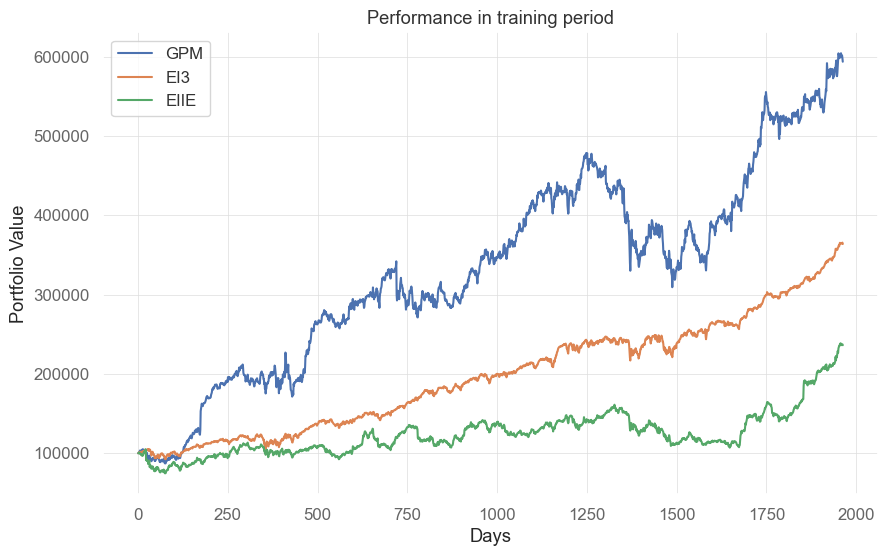

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline 

# plt.plot(UBAH_results["train"], label="Buy and Hold")
plt.plot(config_to_results[GPM][0]["train"], label="GPM")
plt.plot(config_to_results[EIIE][0]["train"], label="EI3")
plt.plot(config_to_results[EI3][0]["train"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()


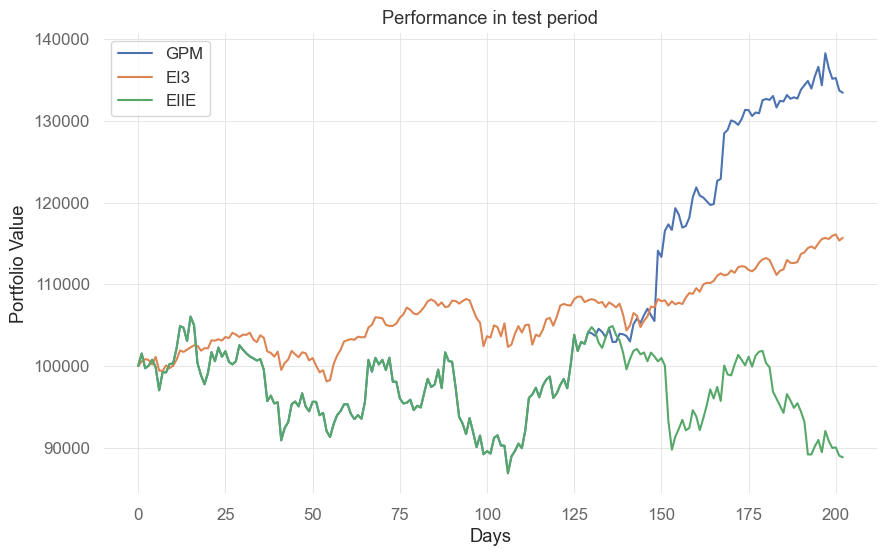

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline 

# plt.plot(UBAH_results["train"], label="Buy and Hold")
plt.plot(config_to_results[GPM][0]["test"], label="GPM")
plt.plot(config_to_results[EIIE][0]["test"], label="EI3")
plt.plot(config_to_results[EI3][0]["test"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in test period")
plt.legend()

plt.show()


In [44]:
len(config_to_results[GPM][0]["test"])

203

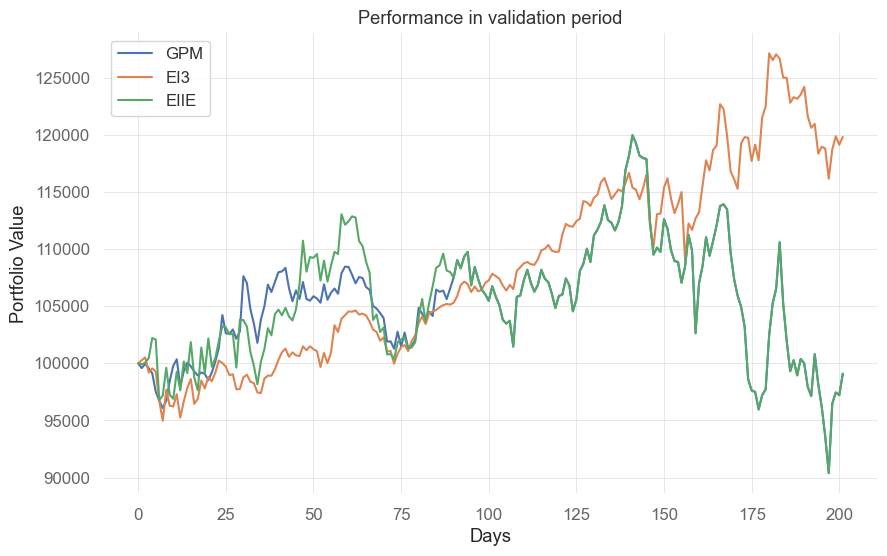

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline 

# plt.plot(UBAH_results["train"], label="Buy and Hold")
plt.plot(config_to_results[GPM][0]["validation"], label="GPM")
plt.plot(config_to_results[EIIE][0]["validation"], label="EI3")
plt.plot(config_to_results[EI3][0]["validation"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in validation period")
plt.legend()

plt.show()
